In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Define the ranges for x and y
scenarios = range(1, 5)
attempts = range(0, 10)
types = ['confort','simple']
models = ['dqn', 'ppo']
# Create a figure for the plots
plt.figure(figsize=(15, 10))

df = pd.DataFrame(columns=['Scenario', 'Model', 'Attempt','Time Step' ,'Speed', 'Action', 'Type'])

# Iterate over the ranges and plot the values
for type in types:
    for model in models:
        for x in scenarios:
            for y in attempts:
                speed_path = f'test_results/speeds/speed_{x}_{model}_{type}_{y}.txt'
                action_path = f'test_results/actions/action_{x}_{model}_{type}_{y}.txt'
                speeds = []
                actions = []

                # Check if the file exists
                if os.path.exists(speed_path):
                    with open(speed_path, 'r') as file:
                        lines = file.readlines()
                        speeds = [float(line.strip()) for line in lines]
                if os.path.exists(action_path):
                    with open(action_path, 'r') as file:
                        lines = file.readlines()
                        actions = [line.strip() for line in lines]
                
                for i in range(len(speeds)):
                    df = pd.concat([df, pd.DataFrame([[x, model.upper(), y, i, speeds[i], actions[i], "Simple" if type == 'simple' else "Comfort"]], columns=['Scenario', 'Model', 'Attempt','Time Step' ,'Speed', 'Action', 'Type'])])
df

C:\Users\ganha\AppData\Local\Temp\ipykernel_14096\2916995026.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[x, model.upper(), y, i, speeds[i], actions[i], "Simple" if type == 'simple' else "Comfort"]], columns=['Scenario', 'Model', 'Attempt','Time Step' ,'Speed', 'Action', 'Type'])])


,Scenario,Model,Attempt,Time Step,Speed,Action,Type
0,1,DQN,0,0,25.000000,1,Comfort
0,1,DQN,0,1,25.000000,0,Comfort
0,1,DQN,0,2,25.000000,0,Comfort
0,1,DQN,0,3,25.000000,0,Comfort
0,1,DQN,0,4,25.000000,0,Comfort
...,...,...,...,...,...,...,...
0,4,PPO,9,12,20.000000,2,Simple
0,4,PPO,9,13,20.000000,3,Simple
0,4,PPO,9,14,24.145559,3,Simple
0,4,PPO,9,15,28.999545,3,Simple


<Figure size 1500x1000 with 0 Axes>

(14468, 7)


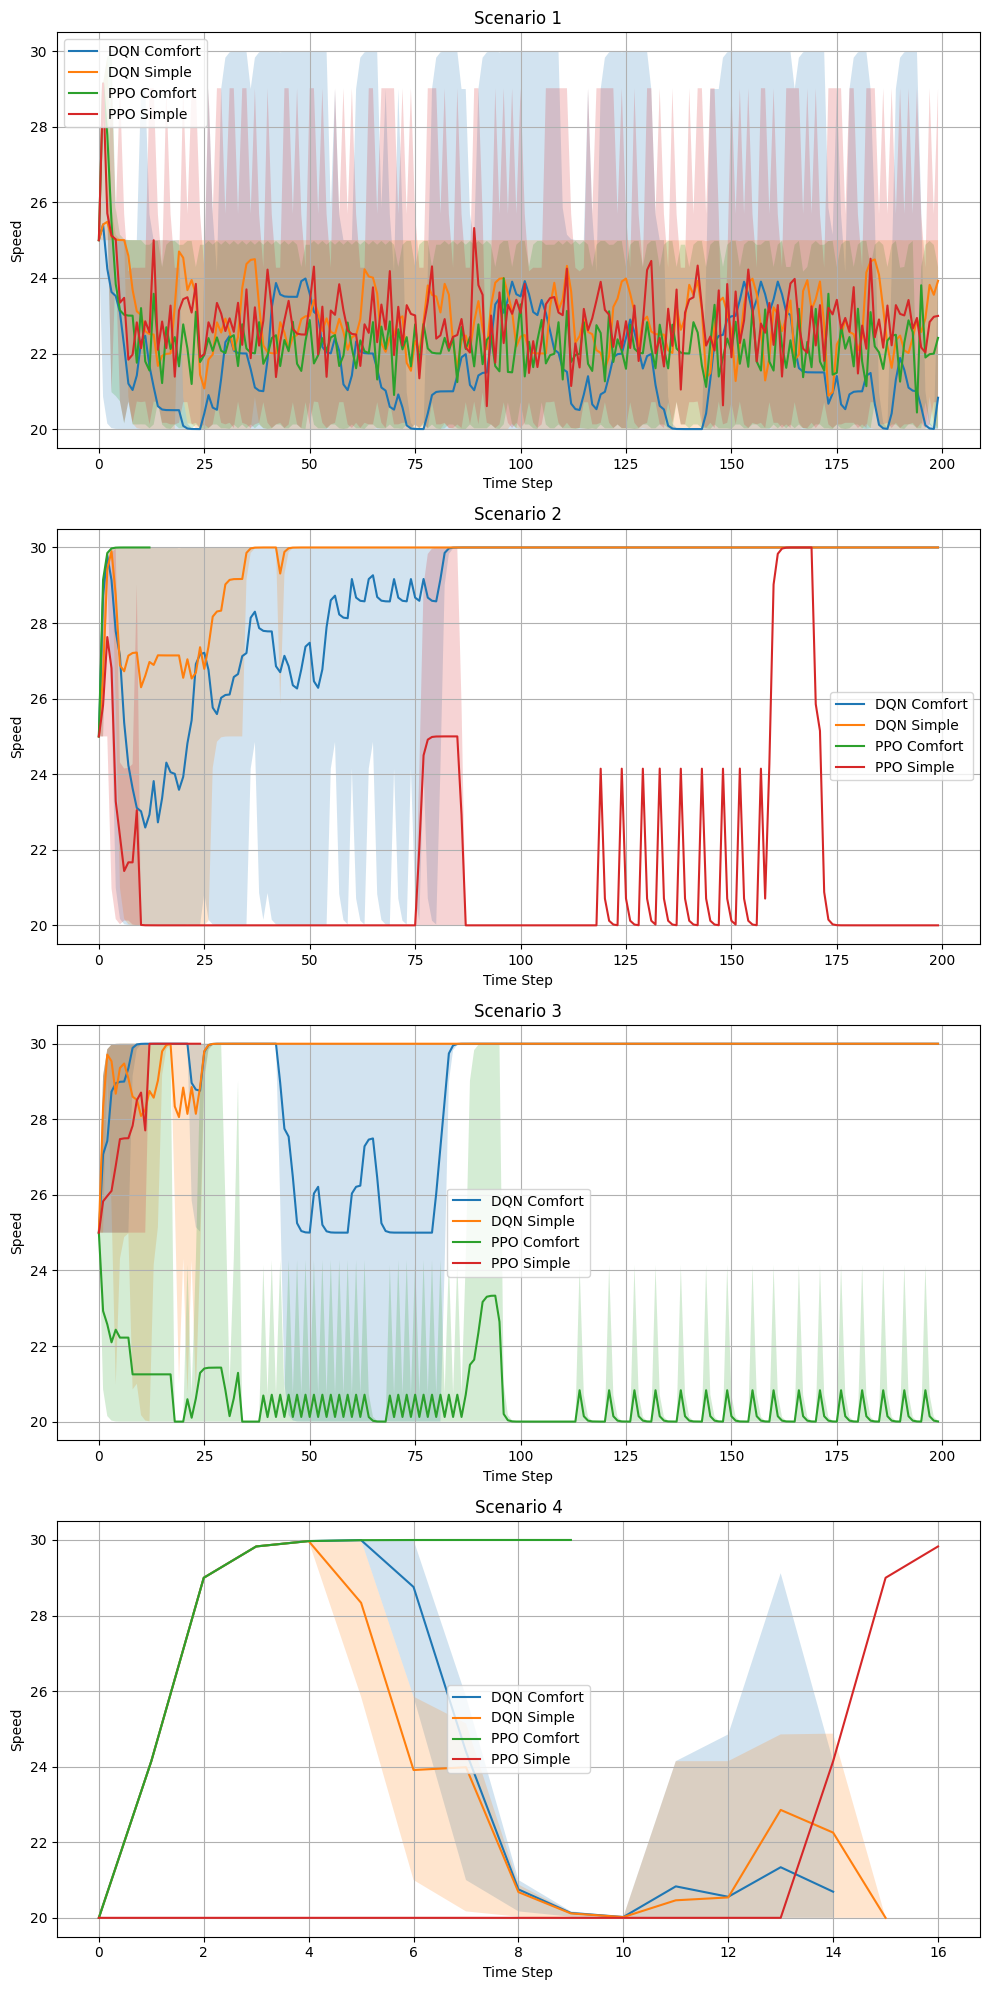

In [3]:
# Calculate average speed grouping by scenario model and time step
df_avg_speed = df.groupby(['Scenario', 'Model', 'Time Step','Type'])['Speed'].mean().reset_index()
df_min_speed = df.groupby(['Scenario', 'Model', 'Time Step','Type'])['Speed'].min().reset_index()
df_max_speed = df.groupby(['Scenario', 'Model', 'Time Step','Type'])['Speed'].max().reset_index()

# Plot the average speed and with shadow min and max
scenarios = df_avg_speed['Scenario'].unique()

# Create subplots
num_scenarios = len(scenarios)
fig, axes = plt.subplots(num_scenarios, 1, figsize=(10, 5 * num_scenarios), sharex=False)

# Plot the average speed with min and max shadows for each scenario
for i, scenario in enumerate(scenarios):
    ax = axes[i] if num_scenarios > 1 else axes
    for model in df_avg_speed['Model'].unique():
        for type in df_avg_speed['Type'].unique():
            df_scenario = df_avg_speed[(df_avg_speed['Scenario'] == scenario) & (df_avg_speed['Model'] == model) & (df_avg_speed['Type'] == type)]
            df_scenario_min = df_min_speed[(df_min_speed['Scenario'] == scenario) & (df_min_speed['Model'] == model) & (df_min_speed['Type'] == type)]
            df_scenario_max = df_max_speed[(df_max_speed['Scenario'] == scenario) & (df_max_speed['Model'] == model) & (df_max_speed['Type'] == type)]          
            ax.plot(df_scenario['Time Step'], df_scenario['Speed'], label=f'{model} {type}')
            ax.fill_between(df_scenario['Time Step'], df_scenario_min['Speed'], df_scenario_max['Speed'], alpha=0.2)
    
    ax.set_title(f'Scenario {scenario}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Speed')
    ax.legend()
    ax.grid(True)

print(df.shape)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [4]:
crash_path = 'test_results/crash.txt'
crash = []
if os.path.exists(crash_path):
    with open(crash_path, 'r') as file:
        lines = file.readlines()
        crash = [line.strip() for line in lines]

df_crash = pd.DataFrame(columns=['Scenario', 'Model','Type', 'Attempt', 'Crash'])
for c in crash:
    scenario, model, type,attempt, crash = c.split('_')
    df_crash = pd.concat([df_crash, pd.DataFrame([[int(scenario), model.upper(), "Simple" if type=='simple' else "Comfort", int(attempt), 0 if crash == "False" else 1]], columns=['Scenario', 'Model', 'Type', 'Attempt', 'Crash'])])
    
df_crash


,Scenario,Model,Type,Attempt,Crash
0,1,DQN,Simple,0,0
0,1,DQN,Comfort,0,0
0,1,PPO,Simple,0,0
0,1,PPO,Comfort,0,0
0,1,DQN,Simple,1,0
...,...,...,...,...,...
0,4,PPO,Comfort,8,1
0,4,DQN,Simple,9,0
0,4,DQN,Comfort,9,0
0,4,PPO,Simple,9,0


In [5]:
# in the df dataframe, add a crash column where the value is true for the last time step of a scenario, model, type and attempt where the df_crash has a crash value of true
df['Crash'] = False

for index, row in df.iterrows():
    scenario = row['Scenario']

    model = row['Model']
    type = row['Type']
    attempt = row['Attempt']
    time_step = row['Time Step']
    if len(df_crash[(df_crash['Scenario'] == scenario) & (df_crash['Model'] == model) & (df_crash['Type'] == type) & (df_crash['Attempt'] == attempt) & (df_crash['Crash'] == True)] ) > 0:
        df.loc[(df['Scenario'] == scenario) & (df['Model'] == model) & (df['Type'] == type) & (df['Attempt'] == attempt) & (df['Time Step'] == time_step), 'Crash'] = True
  


In [6]:
# group by scenario, model, type, attempt and calculate the average speed and select the last time step for the crash column and the percentage between the actions equal 1, 2 or 3 being 1 

agreegated = df.groupby(['Scenario', 'Model', 'Type', 'Attempt']).agg({'Speed': 'mean', 'Crash': 'last', 'Action': lambda x: (x == '1').sum() / sum([1 if (y == "1" or y == "3" or y == "4") else 0 for y in x])}).reset_index()
# rename the column Action to Idle 

agreegated.rename(columns={'Action': 'Idle'}, inplace=True)

agreegated

C:\Users\ganha\AppData\Local\Temp\ipykernel_14096\2800601810.py:3: RuntimeWarning: invalid value encountered in scalar divide
  agreegated = df.groupby(['Scenario', 'Model', 'Type', 'Attempt']).agg({'Speed': 'mean', 'Crash': 'last', 'Action': lambda x: (x == '1').sum() / sum([1 if (y == "1" or y == "3" or y == "4") else 0 for y in x])}).reset_index()


,Scenario,Model,Type,Attempt,Speed,Crash,Idle
0,1,DQN,Comfort,0,22.230153,False,0.703488
1,1,DQN,Comfort,1,20.505153,False,0.259459
2,1,DQN,Comfort,2,20.355153,False,0.265957
3,1,DQN,Comfort,3,22.475881,False,0.655556
4,1,DQN,Comfort,4,21.030153,False,0.748466
...,...,...,...,...,...,...,...
155,4,PPO,Simple,5,21.351420,False,0.166667
156,4,PPO,Simple,6,21.351420,True,0.166667
157,4,PPO,Simple,7,21.351420,False,0.166667
158,4,PPO,Simple,8,21.351420,False,0.166667


In [7]:
# group by scenario, model, type and calculate the average speed, the percentage of crash and the percentage of idle

agreegated_final = agreegated.groupby(['Scenario', 'Model', 'Type']).agg({'Speed': 'mean', 'Crash': lambda x: (x == True).sum() / len(x), 'Idle': 'mean'}).reset_index()

agreegated_final

,Scenario,Model,Type,Speed,Crash,Idle
0,1,DQN,Comfort,21.711798,0.0,0.614903
1,1,DQN,Simple,22.911109,0.0,0.805475
2,1,PPO,Comfort,22.295165,0.0,0.363000
3,1,PPO,Simple,22.892066,0.0,0.000000
4,2,DQN,Comfort,27.498554,0.3,0.196993
5,2,DQN,Simple,28.117433,0.4,0.198545
6,2,PPO,Comfort,28.758984,1.0,0.000000
7,2,PPO,Simple,25.152508,0.9,0.003670
8,3,DQN,Comfort,28.694584,0.6,0.569955
9,3,DQN,Simple,29.037309,0.8,0.317362


# COMPARACAO DE MODELOS

In [8]:
# compare the simple ones only 
agreegated_final_simple = agreegated_final[agreegated_final['Type'] == 'Simple']
# sort the values by the speed
agreegated_final_simple.sort_values(by=['Scenario', 'Model'], ascending=[True, False], inplace=True)
agreegated_final_simple

C:\Users\ganha\AppData\Local\Temp\ipykernel_14096\591607309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agreegated_final_simple.sort_values(by=['Scenario', 'Model'], ascending=[True, False], inplace=True)


,Scenario,Model,Type,Speed,Crash,Idle
3,1,PPO,Simple,22.892066,0.0,0.000000
1,1,DQN,Simple,22.911109,0.0,0.805475
7,2,PPO,Simple,25.152508,0.9,0.003670
5,2,DQN,Simple,28.117433,0.4,0.198545
11,3,PPO,Simple,26.785295,1.0,0.000000
9,3,DQN,Simple,29.037309,0.8,0.317362
15,4,PPO,Simple,21.298435,0.3,0.168182
13,4,DQN,Simple,23.860335,0.1,0.214293


# Comparacao de Comforto

In [9]:
# compare the dqns simple and comfort
agreegated_final_dqn = agreegated_final[agreegated_final['Model'] == 'DQN']

agreegated_final_dqn


,Scenario,Model,Type,Speed,Crash,Idle
0,1,DQN,Comfort,21.711798,0.0,0.614903
1,1,DQN,Simple,22.911109,0.0,0.805475
4,2,DQN,Comfort,27.498554,0.3,0.196993
5,2,DQN,Simple,28.117433,0.4,0.198545
8,3,DQN,Comfort,28.694584,0.6,0.569955
9,3,DQN,Simple,29.037309,0.8,0.317362
12,4,DQN,Comfort,24.126975,0.0,0.208889
13,4,DQN,Simple,23.860335,0.1,0.214293


 importante ressaltar que de vez em quando o gajo fica a spammar 2, para a direita, porque associou a accao para a direita com rewards (idle do sce 2)
 crash diminui